ÜSKÜDAR ÜNİVERSİTESİ FEN BİLİMLERİ ENSTİTÜSÜ

MAKİNE ÖĞRENMESİ-Final Ödevi
Machine Learning Pipeline: Feature Selection and Hyperparameter Optimization

Projenin Amacı
Bu projede, büyük ve çok özellikli bir veri seti olan HIGGS Dataset üzerinde çalışarak makine öğrenmesi sürecinin iki önemli bileşeni olan özellik seçimi (feature selection) ve hiperparametre ayarlaması (hyperparameter tuning) adımlarını uygulayacaksınız.
Bu kapsamda:
•	Aykırı değerleri analiz edeceksiniz,
•	Verileri uygun şekilde ölçekleyeceksiniz,
•	Filtre tabanlı yöntemlerle öznitelik seçeceksiniz,
•	Nested Cross-Validation ile hiperparametre araması yaparak modelleri eğiteceksiniz,
•	KNN, SVM ve MLP, XGBoost algoritmalarını kullanarak performans karşılaştırmaları yapacaksınız,
•	ROC eğrileri ve diğer metriklerle model başarımını yorumlayacaksınız.

Teslim Edilecekler
1.	GitHub linki
o	Tüm kodları, grafik çıktıları ve yorumlarınızı içermeli.
2.	Kısa Rapor (.pdf veya .docx)
o	Tüm kodları, grafik çıktıları ve yorumlarınızı içermeli.
o	Her modelin metrik sonuçları (tablo şeklinde)
o	ROC eğrileri
o	En başarılı model ve veri temsili kombinasyonunun yorumu

















Kullanılacak Veri Seti:
HIGGS Dataset (11 milyon örnek, 28 özellik) Proje için rastgele 100.000 sample kullanılacak
https://archive.ics.uci.edu/ml/datasets/HIGGS

Bölüm 1: Veri Ön İşleme (Preprocessing)
Aykırı Değer Analizi:
•	IQR yöntemi ile aykırı değerler control edilecek.
•	Gerekirse silme veya sınır değerlerle değiştirme yapılacak.
Özellik Ölçekleme:
•	Tüm sayısal değişkenler MinMaxScaler ile [0, 1] aralığına dönüştürülecek.

Bölüm 2: Özellik Seçimi
Filter-Based Feature Selection:
ANOVA F-score veya Mutual Information yöntemlerinden biri ile en iyi 15 özellik seçilecek.

Bölüm 3: Modelleme ve Değerlendirme

Nested Cross-Validation:
•	Outer Loop: 5-fold
•	Inner Loop: 3-fold
•	Flowchart A) İç döngüde farklı öznitelik seçim kombinasyonları denenerek en iyi model ve öznitelikler belirlenir. Figure 1
•	Flowchart B) İç döngüde farklı hiperparametre kombinasyonları denenerek en iyi model ve hiperparametreler belirlenir. Figure2
•	Dış döngüde test performansı değerlendirilir.

Kullanılacak Modeller:
•	K-Nearest Neighbors (KNN)
•	Support Vector Machine (SVM)
•	Multi-Layer Perceptron (MLP)
•	XGBoost

Hiperparametre Aralıkları (Inner CV için): Farklı değerler denenebilir
•	KNN: n_neighbors=3-11 arasında
•	SVM: C=[0.1, 1, 10], kernel=['linear', 'rbf']
•	MLP: hidden_layer_sizes=[(50,), (100,)], activation=['relu', 'tanh']

Performans Metrikleri:
•	Accuracy
•	Precision
•	Recall
•	F1 Score
•	ROC-AUC
ROC Eğrileri (OVA yöntemiyle):
•	Her sınıf için ROC eğrisi çizilecek.
•	AUC skorları görselleştirilecek ve yorumlanacak.
 
Figure 1: Flowchart A

 
Figure 2: Flowchart B





In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

In [2]:
# Veri yükleme ve 100.000 örnek alma
df_all = pd.read_csv("data/HIGGS.csv")
random_state = 42
df = df_all.sample(n=100000, random_state=random_state).reset_index(drop=True)

# Kolon adlarını düzenleme
col_names = ['target'] + [f'feature_{i}' for i in range(1, 29)]
df.columns = col_names

In [3]:
#df.to_csv("data/higgs_sample.csv", index=False)

In [4]:
df.shape
df.describe()
df.isnull().sum()

(100000, 29)

,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.527570,0.993072,-0.004594,-0.001619,1.000523,0.001628,0.990614,0.004351,-0.006783,1.005189,...,0.000114,-0.000895,0.991821,1.032476,1.025954,1.050962,1.012504,0.976152,1.034997,0.962050
std,0.499242,0.569050,1.006792,1.004739,0.604273,1.007999,0.475526,1.012655,1.007179,1.027841,...,1.010942,1.005036,1.398356,0.672843,0.382334,0.162836,0.400912,0.526417,0.365444,0.315153
min,0.000000,0.274697,-2.434976,-1.742508,0.001690,-1.743932,0.161687,-2.969725,-1.741237,0.000000,...,-2.497265,-1.742691,0.000000,0.101603,0.297987,0.234146,0.292503,0.067156,0.340333,0.370761
25%,0.000000,0.590753,-0.741244,-0.871376,0.577388,-0.870600,0.679359,-0.686255,-0.879877,0.000000,...,-0.711692,-0.872589,0.000000,0.789195,0.846650,0.985767,0.769735,0.676853,0.821192,0.772046
50%,1.000000,0.852639,-0.005898,-0.001906,0.891992,-0.000366,0.894728,0.005916,-0.008257,1.086538,...,-0.002959,-0.003039,0.000000,0.894816,0.951562,0.989803,0.917566,0.875394,0.948793,0.874209
75%,1.000000,1.238971,0.734318,0.865445,1.294344,0.879341,1.167351,0.693135,0.861660,2.173076,...,0.718266,0.869386,3.101961,1.025965,1.084962,1.022479,1.145951,1.140926,1.142755,1.060099
max,1.000000,8.790659,2.434868,1.743236,11.531485,1.743257,7.419452,2.966703,1.741454,2.173076,...,2.498009,1.743372,3.101961,18.002125,9.153964,3.954101,8.140121,8.835245,6.775816,5.071645


target        0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
dtype: int64

# Data Preprocessing 

<Axes: xlabel='target', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Target Variable')

Text(0.5, 0, 'Target')

Text(0, 0.5, 'Count')

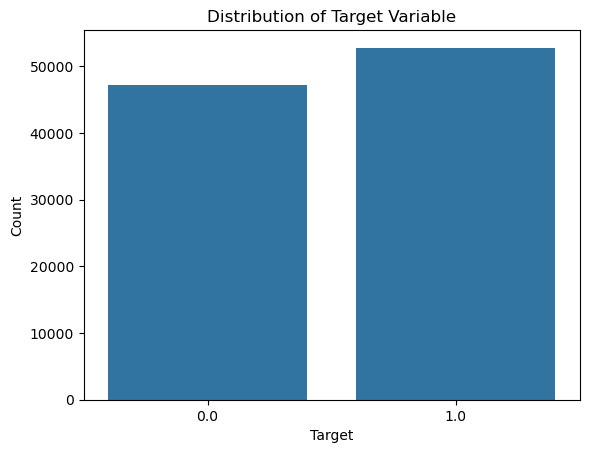

target
1.0    52757
0.0    47243
Name: count, dtype: int64

In [5]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show();

# Display frequency of target values
target_frequency = df['target'].value_counts()
display(target_frequency)

- Histogram Dağılımı Normal/Anormak

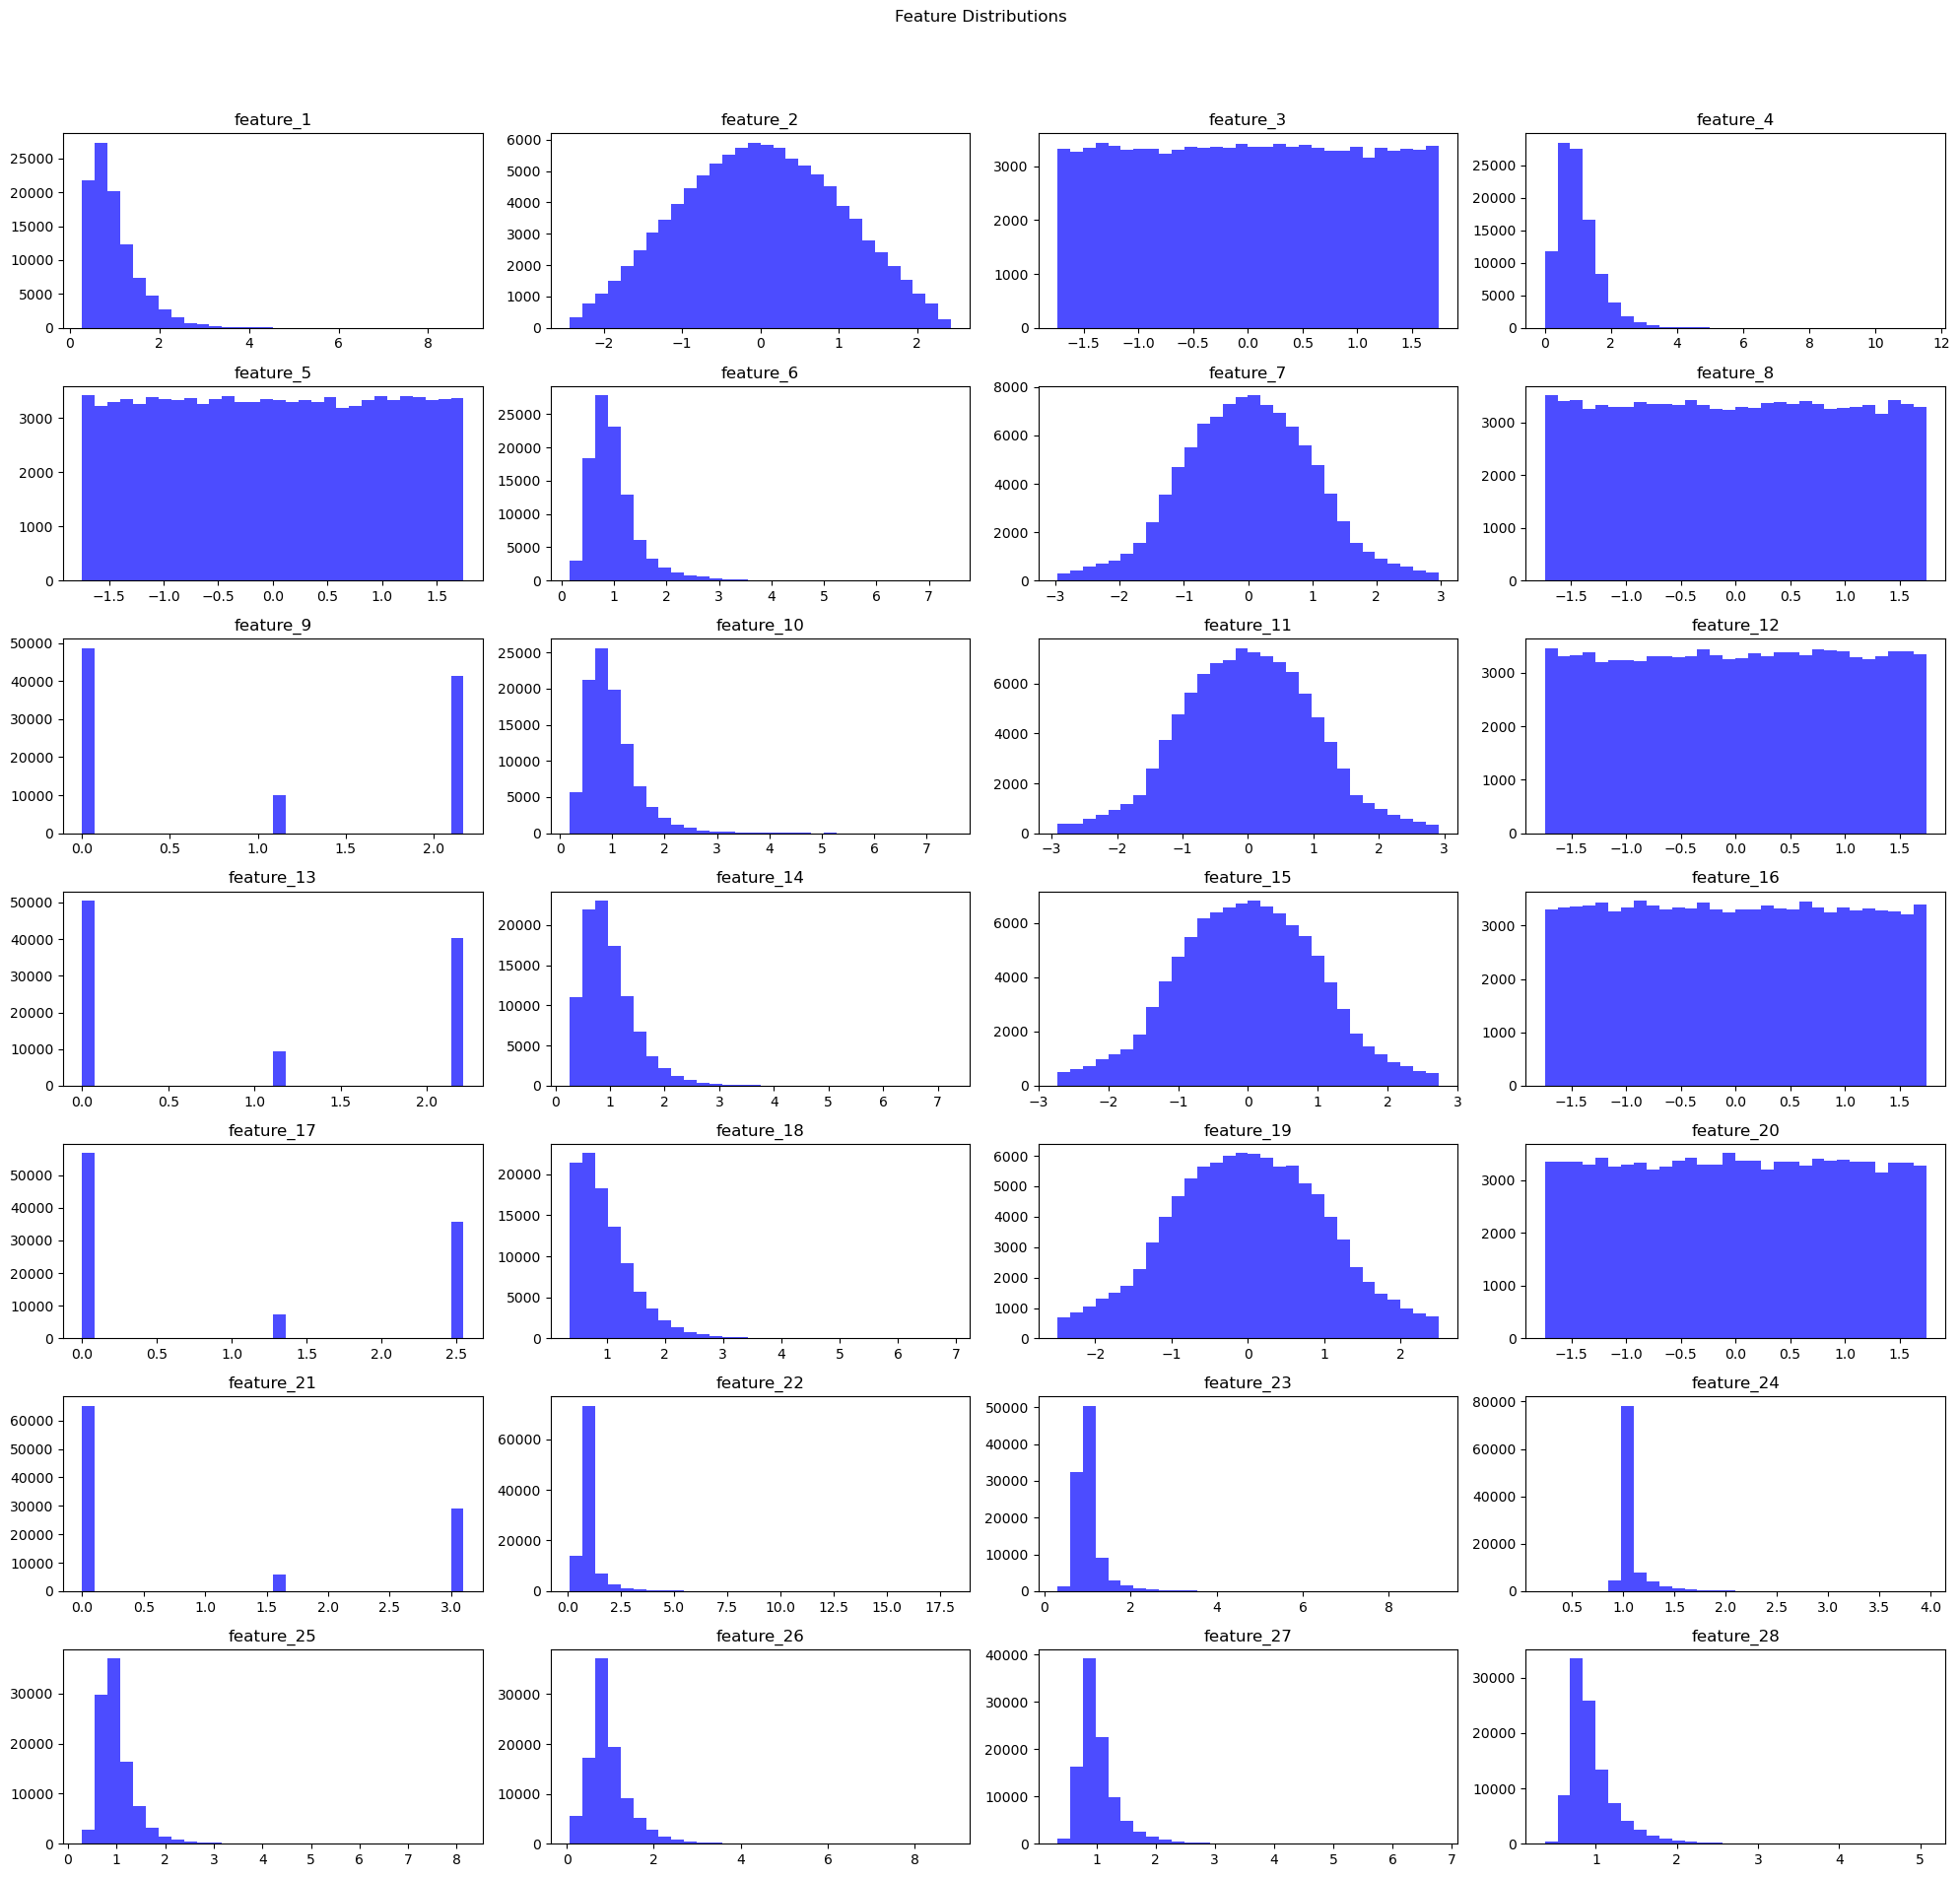

In [6]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
fig.suptitle('Feature Distributions')
axes = axes.ravel()

for i in range(1, 29):
    axes[i-1].hist(df[f'feature_{i}'], bins=30, alpha=0.7, color='blue')
    axes[i-1].set_title(f'feature_{i}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

- Boxplot kullanarak IQR Grafiği

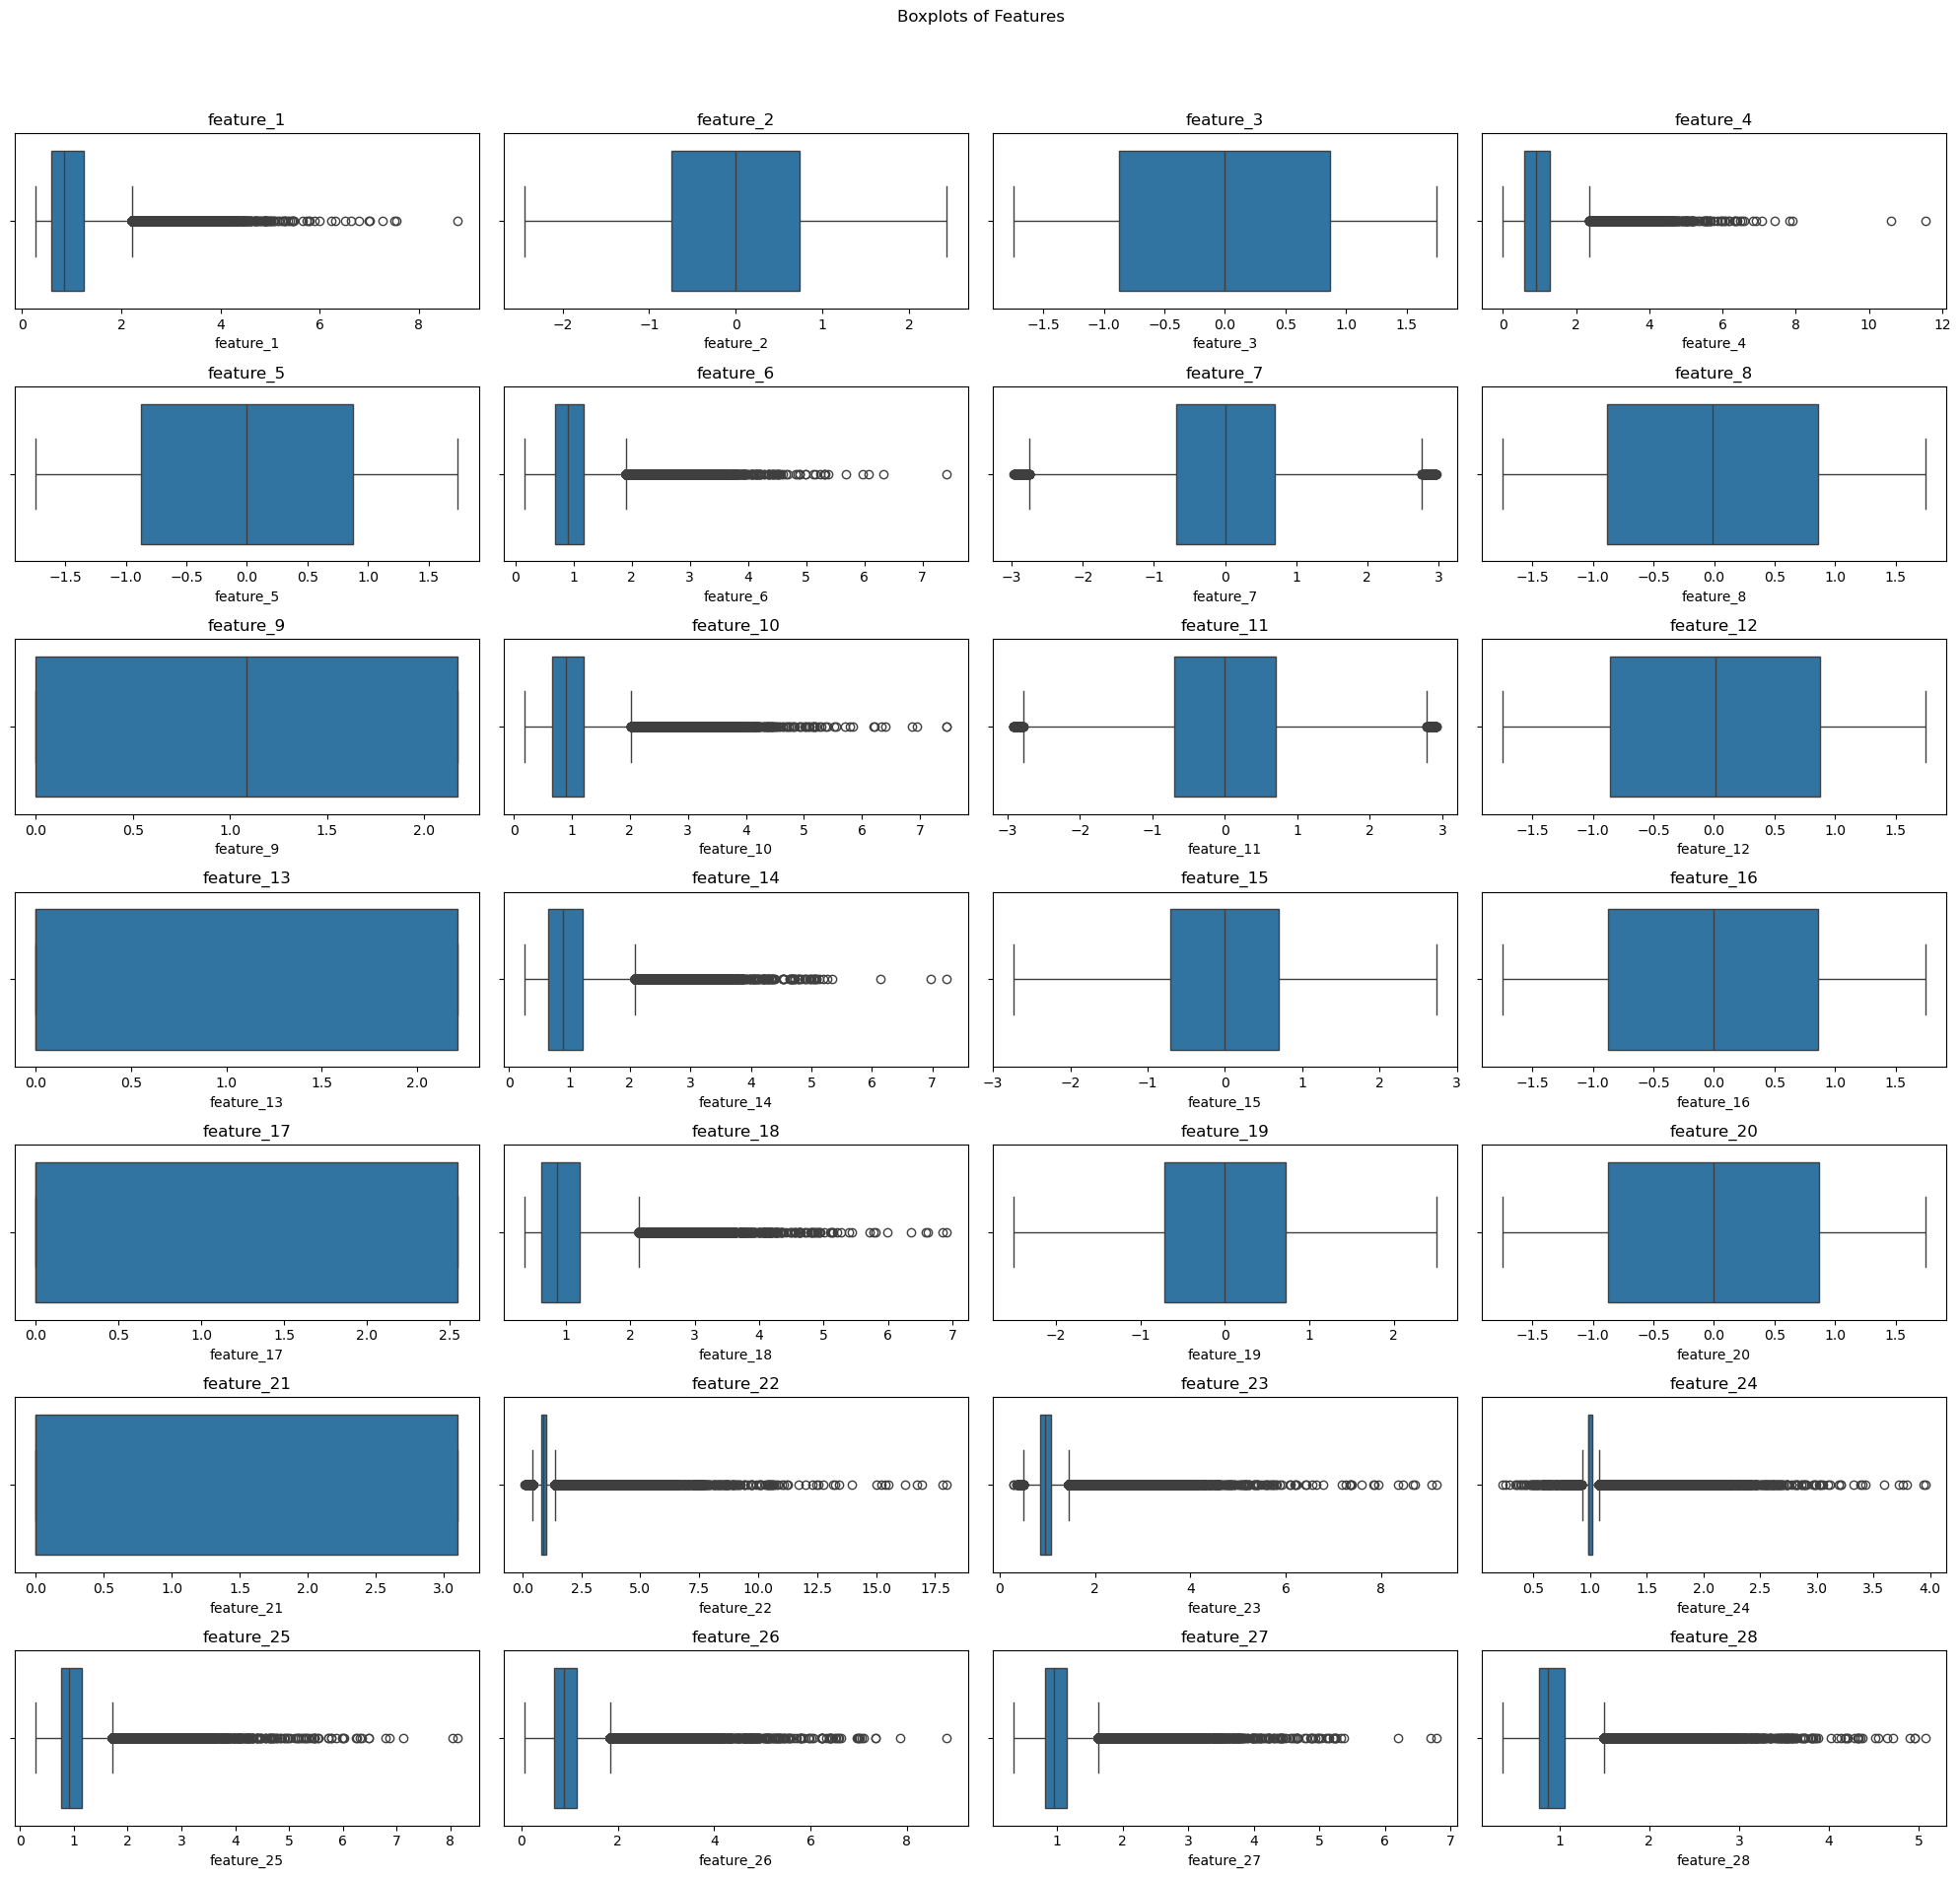

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
fig.suptitle('Boxplots of Features')
axes = axes.ravel()
for i in range(1, 29):
    sns.boxplot(data=df, x=f'feature_{i}', ax=axes[i-1])
    axes[i-1].set_title(f'feature_{i}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

- Z score hesaplama

In [8]:
# Z-score ile aykırı değer tespiti ve winsorizing
features_only = df.drop(columns=["target"])
z_scores = features_only.apply(zscore)

- Outliers tespiti

In [9]:
# Aykırı değer eşiği (yaklaşık z=2.77 → %99 güvenli)
threshold = 2.77
print(f"Otomatik Z-score eşiği: {threshold:.2f}")

# Aykırı değerleri eşik değerde sınırla (winsorizing)
winsorized_df = features_only.copy()
for col in winsorized_df.columns:
    upper_limit = winsorized_df[col].mean() + threshold * winsorized_df[col].std()
    lower_limit = winsorized_df[col].mean() - threshold * winsorized_df[col].std()
    winsorized_df[col] = np.clip(winsorized_df[col], lower_limit, upper_limit)

Otomatik Z-score eşiği: 2.77


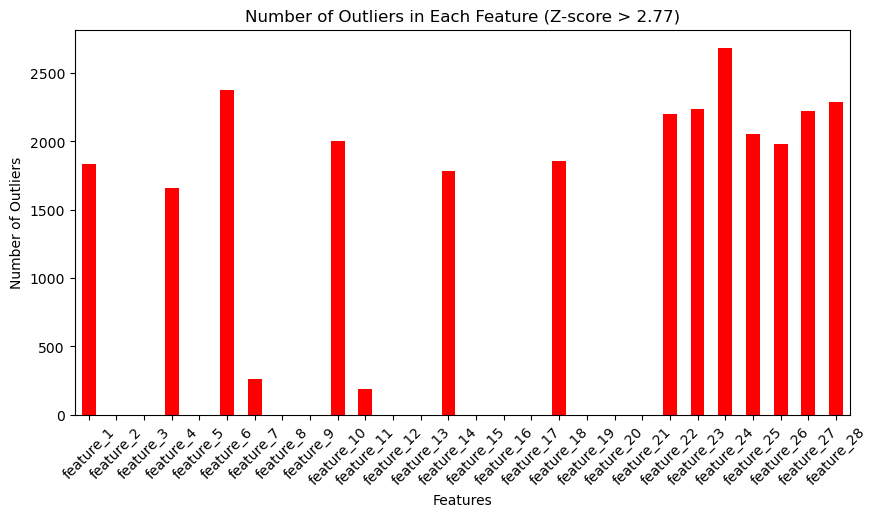

,Feature,Number of Outliers
feature_1,feature_1,1836
feature_2,feature_2,0
feature_3,feature_3,0
feature_4,feature_4,1656
feature_5,feature_5,0
feature_6,feature_6,2376
feature_7,feature_7,264
feature_8,feature_8,0
feature_9,feature_9,0
feature_10,feature_10,1999


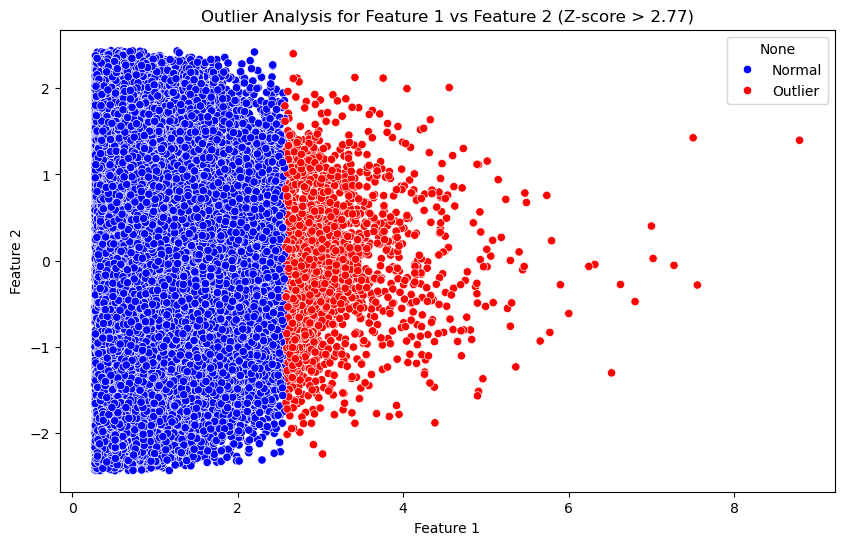

In [10]:
clean_df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate Z-scores to identify potential outliers
from scipy.stats import zscore
z_scores = clean_df.drop(columns=['target']).apply(zscore)
outliers = (z_scores > 2.77).sum()
plt.figure(figsize=(10, 5))
outliers.plot(kind='bar', color='red')
plt.title('Number of Outliers in Each Feature (Z-score > 2.77)')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.show()

# Display detailed outlier information for each feature
outlier_info = pd.DataFrame({'Feature': z_scores.columns, 'Number of Outliers': outliers})
display(outlier_info)

# Visualize outliers using scatter plots for selected features
plt.figure(figsize=(10, 6))
outlier_mask = (z_scores['feature_1'] > 2.77) | (z_scores['feature_2'] > 2.77)
sns.scatterplot(data=clean_df, x='feature_1', y='feature_2', hue=outlier_mask.map({True: 'Outlier', False: 'Normal'}), palette={'Outlier': 'red', 'Normal': 'blue'})
plt.title('Outlier Analysis for Feature 1 vs Feature 2 (Z-score > 2.77)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show();

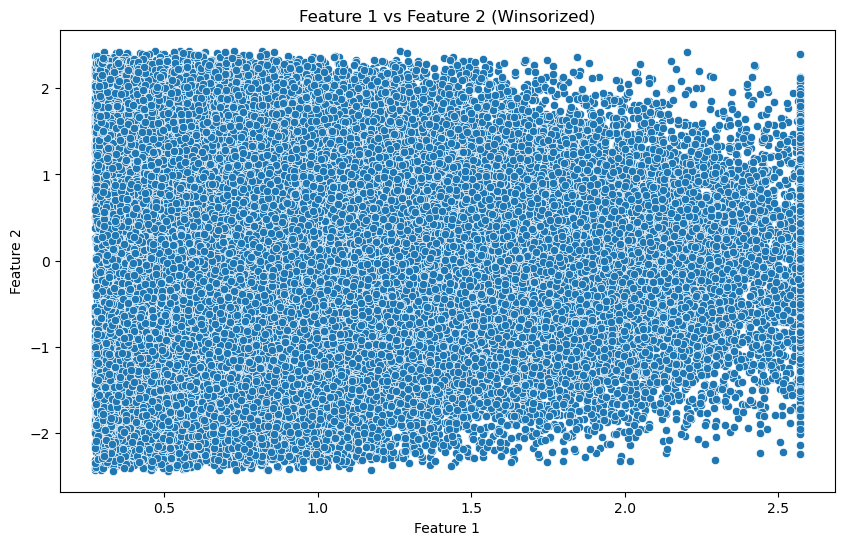

In [19]:
# Aykırı değer sonrası scatter örneği
plt.figure(figsize=(10, 6))
sns.scatterplot(data=winsorized_df.join(df['target']), x='feature_1', y='feature_2')
plt.title('Feature 1 vs Feature 2 (Winsorized)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show();

In [12]:
# MinMaxScaler ile ölçekleme (proje gereği)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(winsorized_df)
scaled_df = pd.DataFrame(scaled_features, columns=winsorized_df.columns)
scaled_df['target'] = df['target']  # Hedef sütun ekle

In [13]:
scaled_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,target
0,0.112295,0.3842,0.297030,0.254917,0.701456,0.886734,0.280350,0.508770,0.0,0.676122,...,0.109993,0.0,0.204085,1.000000,0.422950,0.307976,0.392219,0.955517,0.761934,1.0
1,0.028951,0.5142,0.593295,1.000000,0.643529,0.823859,0.358367,0.126548,1.0,0.394428,...,0.870427,1.0,0.963395,0.865701,0.411730,1.000000,0.473459,0.971577,1.000000,0.0
2,0.650800,0.4536,0.116997,0.516566,0.562558,0.143890,0.400728,0.692305,0.0,0.248179,...,0.921843,0.0,0.313536,0.256502,1.000000,0.480736,0.246659,0.284455,0.259051,1.0
3,0.192528,0.3356,0.142625,0.241834,0.779024,0.204375,0.626659,0.970392,0.0,0.448687,...,0.757887,1.0,0.496235,0.346874,0.425598,0.272574,0.179177,0.229893,0.259455,0.0
4,0.023049,0.7866,0.824106,0.445359,0.704625,0.336271,0.656842,0.046958,1.0,0.114931,...,0.361976,1.0,0.268790,0.545426,0.435673,0.290404,0.490361,0.317914,0.296762,0.0


# Özellik Seçimi

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# X ve y'yi ayır
X = scaled_df.drop(columns=['target'])
y = scaled_df['target']

# En iyi 15 özelliği seç (ANOVA F-score yöntemi ile)
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# Seçilen sütun isimlerini al
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print("Seçilen Özellikler:", selected_features.tolist())

# Yeni veri seti
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_selected_df['target'] = y.reset_index(drop=True)
X_selected_df.head()

Seçilen Özellikler: ['feature_1', 'feature_4', 'feature_6', 'feature_10', 'feature_13', 'feature_17', 'feature_18', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28']


,feature_1,feature_4,feature_6,feature_10,feature_13,feature_17,feature_18,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,target
0,0.112295,0.254917,0.886734,0.676122,1.0,1.0,0.643644,0.0,0.204085,1.000000,0.422950,0.307976,0.392219,0.955517,0.761934,1.0
1,0.028951,1.000000,0.823859,0.394428,0.0,0.0,0.239085,1.0,0.963395,0.865701,0.411730,1.000000,0.473459,0.971577,1.000000,0.0
2,0.650800,0.516566,0.143890,0.248179,1.0,1.0,0.051876,0.0,0.313536,0.256502,1.000000,0.480736,0.246659,0.284455,0.259051,1.0
3,0.192528,0.241834,0.204375,0.448687,0.0,1.0,0.276431,1.0,0.496235,0.346874,0.425598,0.272574,0.179177,0.229893,0.259455,0.0
4,0.023049,0.445359,0.336271,0.114931,0.0,0.0,0.455354,1.0,0.268790,0.545426,0.435673,0.290404,0.490361,0.317914,0.296762,0.0


## Nested CV ve FLOWCHART A

In [15]:
# X ve y Özellik Seçiminde olan değişkeni yaz
X = X_selected_df.drop(columns=["target"])
y = X_selected_df["target"]
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]


print("=== FLOWCHART A: Özellik seçimi + hiperparametre tuning (pipeline içinde) ===\n")

models_a = {
    "KNN": (KNeighborsClassifier(), {
        "select__k": [10, 15],
        "clf__n_neighbors": [3, 5, 7]
    }),
    "SVM": (SVC(probability=True), {
        "select__k": [10, 15],
        "clf__C": [0.1, 1],
        "clf__kernel": ["linear"]
    }),
    "MLP": (MLPClassifier(max_iter=300), {
        "select__k": [10, 15],
        "clf__hidden_layer_sizes": [(50,), (100,)],
        "clf__activation": ["relu", "tanh"]
    }),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        "select__k": [10, 15],
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5]
    })
}

# Sonuçları saklamak için
results = {}
best_models = {}

for name, (model, params) in models_a.items():
    pipeline = Pipeline([
        ("select", SelectKBest(score_func=f_classif)),
        ("clf", model)
    ])
    
    # GridSearchCV ile en iyi parametreleri bul
    grid = GridSearchCV(pipeline, params, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
    
    # Outer CV ile performansı değerlendir
    scores = cross_validate(grid, X, y, cv=outer_cv, scoring=scoring, return_estimator=True)
    
    # En iyi modeli sakla (ilk fold'dan)
    grid.fit(X, y)  # Tüm veri ile fit et
    best_models[name] = {
        'estimator': grid.best_estimator_,
        'params': grid.best_params_,
        'best_score': grid.best_score_
    }
    
    # Sonuçları sakla
    model_results = {}
    print(f"Model: {name}")
    print(f"En İyi Parametreler: {grid.best_params_}")
    print(f"En İyi CV Skoru (ROC-AUC): {grid.best_score_:.4f}")
    
    for metric in scores:
        if metric.startswith("test_"):
            metric_name = metric.replace("test_", "")
            mean_score = np.mean(scores[metric])
            std_score = np.std(scores[metric])
            model_results[metric_name] = mean_score
            print(f"{metric_name}: {mean_score:.4f} (±{std_score:.4f})")
    
    results[name] = model_results
    print("-" * 70)

print("\n" + "="*80)
print("EN İYİ MODELLER ÖZET TABLOSU")
print("="*80)

# Her metrik için en iyi modeli bul
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
best_performers = {}

for metric in metrics:
    best_model = max(results.keys(), key=lambda x: results[x][metric])
    best_score = results[best_model][metric]
    best_performers[metric] = (best_model, best_score)

# En iyi performansları göster
print("\nHER METRİK İÇİN EN İYİ MODELLER:")
print("-" * 50)
for metric, (model_name, score) in best_performers.items():
    print(f"{metric.upper():12}: {model_name:8} ({score:.4f})")
    print(f"             Parametreler: {best_models[model_name]['params']}")
    print()

# Genel en iyi model (ROC-AUC'ye göre)
overall_best = max(results.keys(), key=lambda x: results[x]["roc_auc"])
print(f"\nGENEL EN İYİ MODEL (ROC-AUC): {overall_best}")
print(f"ROC-AUC Skoru: {results[overall_best]['roc_auc']:.4f}")
print(f"En İyi Parametreler: {best_models[overall_best]['params']}")

# Tüm metriklerde detaylı karşılaştırma tablosu
print("\n" + "="*80)
print("DETAYLI MODEL KARŞILAŞTIRMA TABLOSU")
print("="*80)
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<9} {'F1':<9} {'ROC-AUC':<9}")
print("-" * 65)

for model_name in results:
    row = f"{model_name:<10}"
    for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        row += f" {results[model_name][metric]:<9.4f}"
    print(row)

# En iyi modelin pipeline'ını göster
print(f"\n{'='*80}")
print(f"EN İYİ MODELİN DETAYLARI ({overall_best})")
print("="*80)
best_pipeline = best_models[overall_best]['estimator']
print("Pipeline Adımları:")
for step_name, step in best_pipeline.named_steps.items():
    print(f"  {step_name}: {step}")

# Özellik seçimi sonuçları
if hasattr(best_pipeline.named_steps['select'], 'get_support'):
    selected_features = best_pipeline.named_steps['select'].get_support()
    print(f"\nSeçilen özellik sayısı: {sum(selected_features)}")
    if hasattr(best_pipeline.named_steps['select'], 'scores_'):
        feature_scores = best_pipeline.named_steps['select'].scores_
        print("En yüksek skorlu özellikler:")
        sorted_indices = np.argsort(feature_scores)[::-1][:10]
        for i, idx in enumerate(sorted_indices):
            if selected_features[idx]:
                print(f"  {i+1}. Özellik {idx}: {feature_scores[idx]:.4f}")


=== FLOWCHART A: Özellik seçimi + hiperparametre tuning (pipeline içinde) ===



GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [3, 5, 7], 'select__k': [10, 15]},
             scoring='roc_auc')

Model: KNN
En İyi Parametreler: {'clf__n_neighbors': 7, 'select__k': 15}
En İyi CV Skoru (ROC-AUC): 0.7151
accuracy: 0.6638 (±0.0041)
precision: 0.6701 (±0.0032)
recall: 0.7147 (±0.0059)
f1: 0.6917 (±0.0042)
roc_auc: 0.7178 (±0.0025)
----------------------------------------------------------------------


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('clf', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1], 'clf__kernel': ['linear'],
                         'select__k': [10, 15]},
             scoring='roc_auc')

Model: SVM
En İyi Parametreler: {'clf__C': 1, 'clf__kernel': 'linear', 'select__k': 15}
En İyi CV Skoru (ROC-AUC): 0.6827
accuracy: 0.6429 (±0.0018)
precision: 0.6253 (±0.0015)
recall: 0.8062 (±0.0026)
f1: 0.7043 (±0.0015)
roc_auc: 0.6827 (±0.0019)
----------------------------------------------------------------------


C:\Users\besir\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('clf', MLPClassifier(max_iter=300))]),
             n_jobs=-1,
             param_grid={'clf__activation': ['relu', 'tanh'],
                         'clf__hidden_layer_sizes': [(50,), (100,)],
                         'select__k': [10, 15]},
             scoring='roc_auc')

Model: MLP
En İyi Parametreler: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'select__k': 15}
En İyi CV Skoru (ROC-AUC): 0.7982
accuracy: 0.7241 (±0.0048)
precision: 0.7305 (±0.0112)
recall: 0.7574 (±0.0308)
f1: 0.7431 (±0.0106)
roc_auc: 0.8012 (±0.0044)
----------------------------------------------------------------------


C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:34:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:34:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:34:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:34:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [3, 5],
                         'clf__n_estimators': [50, 100],
                         'select__k': [10, 15]},
             scoring='roc_auc')

Model: XGBoost
En İyi Parametreler: {'clf__max_depth': 5, 'clf__n_estimators': 100, 'select__k': 15}
En İyi CV Skoru (ROC-AUC): 0.8014
accuracy: 0.7226 (±0.0042)
precision: 0.7326 (±0.0038)
recall: 0.7467 (±0.0045)
f1: 0.7396 (±0.0041)
roc_auc: 0.8021 (±0.0034)
----------------------------------------------------------------------

EN İYİ MODELLER ÖZET TABLOSU

HER METRİK İÇİN EN İYİ MODELLER:
--------------------------------------------------
ACCURACY    : MLP      (0.7241)
             Parametreler: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'select__k': 15}

PRECISION   : XGBoost  (0.7326)
             Parametreler: {'clf__max_depth': 5, 'clf__n_estimators': 100, 'select__k': 15}

RECALL      : SVM      (0.8062)
             Parametreler: {'clf__C': 1, 'clf__kernel': 'linear', 'select__k': 15}

F1          : MLP      (0.7431)
             Parametreler: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'select__k': 15}

ROC_AUC     : XGBoost  (0.8021)

## FLOWCHART B

In [16]:
print("\n" + "="*80)
print("=== FLOWCHART B: Özellik seçimi dışta, iç döngüde sadece hiperparametre tuning ===")
print("="*80)

selector_b = SelectKBest(score_func=f_classif, k=15)
X_selected = selector_b.fit_transform(X, y)

models_b = {
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7]
    }),
    "SVM": (SVC(probability=True), {
        "C": [0.1, 1],
        "kernel": ["linear"]
    }),
    "MLP": (MLPClassifier(max_iter=300), {
        "hidden_layer_sizes": [(50,), (100,)],
        "activation": ["relu", "tanh"]
    }),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5]
    })
}

# Sonuçları saklamak için
results_b = {}
best_models_b = {}

for name, (model, params) in models_b.items():
    # GridSearchCV ile en iyi parametreleri bul
    grid = GridSearchCV(model, params, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
    
    # Outer CV ile performansı değerlendir
    scores = cross_validate(grid, X_selected, y, cv=outer_cv, scoring=scoring, return_estimator=True)
    
    # En iyi modeli sakla
    grid.fit(X_selected, y)  # Tüm veri ile fit et
    best_models_b[name] = {
        'estimator': grid.best_estimator_,
        'params': grid.best_params_,
        'best_score': grid.best_score_
    }
    
    # Sonuçları sakla
    model_results = {}
    print(f"Model: {name}")
    print(f"En İyi Parametreler: {grid.best_params_}")
    print(f"En İyi CV Skoru (ROC-AUC): {grid.best_score_:.4f}")
    
    for metric in scores:
        if metric.startswith("test_"):
            metric_name = metric.replace("test_", "")
            mean_score = np.mean(scores[metric])
            std_score = np.std(scores[metric])
            model_results[metric_name] = mean_score
            print(f"{metric_name}: {mean_score:.4f} (±{std_score:.4f})")
    
    results_b[name] = model_results
    print("-" * 70)

print("\n" + "="*80)
print("FLOWCHART B - EN İYİ MODELLER ÖZET TABLOSU")
print("="*80)

# Her metrik için en iyi modeli bul
best_performers_b = {}

for metric in metrics:
    best_model = max(results_b.keys(), key=lambda x: results_b[x][metric])
    best_score = results_b[best_model][metric]
    best_performers_b[metric] = (best_model, best_score)

# En iyi performansları göster
print("\nHER METRİK İÇİN EN İYİ MODELLER (FLOWCHART B):")
print("-" * 50)
for metric, (model_name, score) in best_performers_b.items():
    print(f"{metric.upper():12}: {model_name:8} ({score:.4f})")
    print(f"             Parametreler: {best_models_b[model_name]['params']}")
    print()

# Genel en iyi model (ROC-AUC'ye göre)
overall_best_b = max(results_b.keys(), key=lambda x: results_b[x]["roc_auc"])
print(f"\nGENEL EN İYİ MODEL (ROC-AUC) - FLOWCHART B: {overall_best_b}")
print(f"ROC-AUC Skoru: {results_b[overall_best_b]['roc_auc']:.4f}")
print(f"En İyi Parametreler: {best_models_b[overall_best_b]['params']}")

# Tüm metriklerde detaylı karşılaştırma tablosu
print("\n" + "="*80)
print("FLOWCHART B - DETAYLI MODEL KARŞILAŞTIRMA TABLOSU")
print("="*80)
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<9} {'F1':<9} {'ROC-AUC':<9}")
print("-" * 65)

for model_name in results_b:
    row = f"{model_name:<10}"
    for metric in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        row += f" {results_b[model_name][metric]:<9.4f}"
    print(row)

# En iyi modelin detayları
print(f"\n{'='*80}")
print(f"FLOWCHART B - EN İYİ MODELİN DETAYLARI ({overall_best_b})")
print("="*80)
best_model_b = best_models_b[overall_best_b]['estimator']
print(f"Model: {best_model_b}")
print(f"Parametreler: {best_models_b[overall_best_b]['params']}")

# Seçilen özellikler hakkında bilgi
selected_features_b = selector_b.get_support()
feature_scores_b = selector_b.scores_
print(f"\nÖzellik Seçimi Bilgileri:")
print(f"Seçilen özellik sayısı: {sum(selected_features_b)} / {len(selected_features_b)}")
print("En yüksek skorlu seçilen özellikler:")
sorted_indices_b = np.argsort(feature_scores_b)[::-1]
selected_count = 0
for i, idx in enumerate(sorted_indices_b):
    if selected_features_b[idx] and selected_count < 10:
        print(f"  {selected_count+1}. Özellik {idx}: {feature_scores_b[idx]:.4f}")
        selected_count += 1



=== FLOWCHART B: Özellik seçimi dışta, iç döngüde sadece hiperparametre tuning ===


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='roc_auc')

Model: KNN
En İyi Parametreler: {'n_neighbors': 7}
En İyi CV Skoru (ROC-AUC): 0.7151
accuracy: 0.6657 (±0.0026)
precision: 0.6715 (±0.0026)
recall: 0.7175 (±0.0023)
f1: 0.6937 (±0.0022)
roc_auc: 0.7196 (±0.0023)
----------------------------------------------------------------------


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'kernel': ['linear']},
             scoring='roc_auc')

Model: SVM
En İyi Parametreler: {'C': 1, 'kernel': 'linear'}
En İyi CV Skoru (ROC-AUC): 0.6827
accuracy: 0.6429 (±0.0018)
precision: 0.6253 (±0.0015)
recall: 0.8062 (±0.0026)
f1: 0.7043 (±0.0015)
roc_auc: 0.6827 (±0.0019)
----------------------------------------------------------------------


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=MLPClassifier(max_iter=300), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,)]},
             scoring='roc_auc')

Model: MLP
En İyi Parametreler: {'activation': 'relu', 'hidden_layer_sizes': (100,)}
En İyi CV Skoru (ROC-AUC): 0.7999
accuracy: 0.7214 (±0.0055)
precision: 0.7323 (±0.0251)
recall: 0.7489 (±0.0489)
f1: 0.7388 (±0.0127)
roc_auc: 0.8009 (±0.0047)
----------------------------------------------------------------------


C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:55:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5], 'n_estimators': [50, 100]},
             scoring='roc_auc')

Model: XGBoost
En İyi Parametreler: {'max_depth': 5, 'n_estimators': 100}
En İyi CV Skoru (ROC-AUC): 0.8014
accuracy: 0.7226 (±0.0042)
precision: 0.7326 (±0.0038)
recall: 0.7467 (±0.0045)
f1: 0.7396 (±0.0041)
roc_auc: 0.8021 (±0.0034)
----------------------------------------------------------------------

FLOWCHART B - EN İYİ MODELLER ÖZET TABLOSU

HER METRİK İÇİN EN İYİ MODELLER (FLOWCHART B):
--------------------------------------------------
ACCURACY    : XGBoost  (0.7226)
             Parametreler: {'max_depth': 5, 'n_estimators': 100}

PRECISION   : XGBoost  (0.7326)
             Parametreler: {'max_depth': 5, 'n_estimators': 100}

RECALL      : SVM      (0.8062)
             Parametreler: {'C': 1, 'kernel': 'linear'}

F1          : XGBoost  (0.7396)
             Parametreler: {'max_depth': 5, 'n_estimators': 100}

ROC_AUC     : XGBoost  (0.8021)
             Parametreler: {'max_depth': 5, 'n_estimators': 100}


GENEL EN İYİ MODEL (ROC-AUC) - FLOWCHART B: XGBoost
ROC-AUC Skoru: 0.

## FLOWCHART A vs B KARŞILAŞTIRMA

In [17]:

print("\n" + "="*80)
print("FLOWCHART A vs FLOWCHART B KARŞILAŞTIRMA")
print("="*80)
print(f"{'Metrik':<12} {'A - En İyi':<15} {'A - Skor':<12} {'B - En İyi':<15} {'B - Skor':<12} {'Kazanan':<10}")
print("-" * 85)

for metric in metrics:
    a_best, a_score = best_performers[metric]
    b_best, b_score = best_performers_b[metric]
    winner = "A" if a_score > b_score else "B" if b_score > a_score else "Berabere"
    print(f"{metric.upper():<12} {a_best:<15} {a_score:<12.4f} {b_best:<15} {b_score:<12.4f} {winner:<10}")

print(f"\nGENEL KAZANAN (ROC-AUC bazında):")
a_overall_score = results[overall_best]['roc_auc']
b_overall_score = results_b[overall_best_b]['roc_auc']
if a_overall_score > b_overall_score:
    print(f"FLOWCHART A ({overall_best}: {a_overall_score:.4f}) > FLOWCHART B ({overall_best_b}: {b_overall_score:.4f})")
elif b_overall_score > a_overall_score:
    print(f"FLOWCHART B ({overall_best_b}: {b_overall_score:.4f}) > FLOWCHART A ({overall_best}: {a_overall_score:.4f})")
else:
    print(f"Berabere: {a_overall_score:.4f}")


FLOWCHART A vs FLOWCHART B KARŞILAŞTIRMA
Metrik       A - En İyi      A - Skor     B - En İyi      B - Skor     Kazanan   
-------------------------------------------------------------------------------------
ACCURACY     MLP             0.7241       XGBoost         0.7226       A         
PRECISION    XGBoost         0.7326       XGBoost         0.7326       Berabere  
RECALL       SVM             0.8062       SVM             0.8062       Berabere  
F1           MLP             0.7431       XGBoost         0.7396       A         
ROC_AUC      XGBoost         0.8021       XGBoost         0.8021       Berabere  

GENEL KAZANAN (ROC-AUC bazında):
Berabere: 0.8021


# ROC eğrisi Kodlar


ROC EĞRİLERİ ÇİZİMİ
FLOWCHART A kullanılıyor (en iyi genel performans)


<Figure size 1200x800 with 0 Axes>

Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', KNeighborsClassifier(n_neighbors=7))])

Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', MLPClassifier(max_iter=300))])

C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:22:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curves - A Approach (Test Set)')

(0.0, 1.0)

(0.0, 1.05)

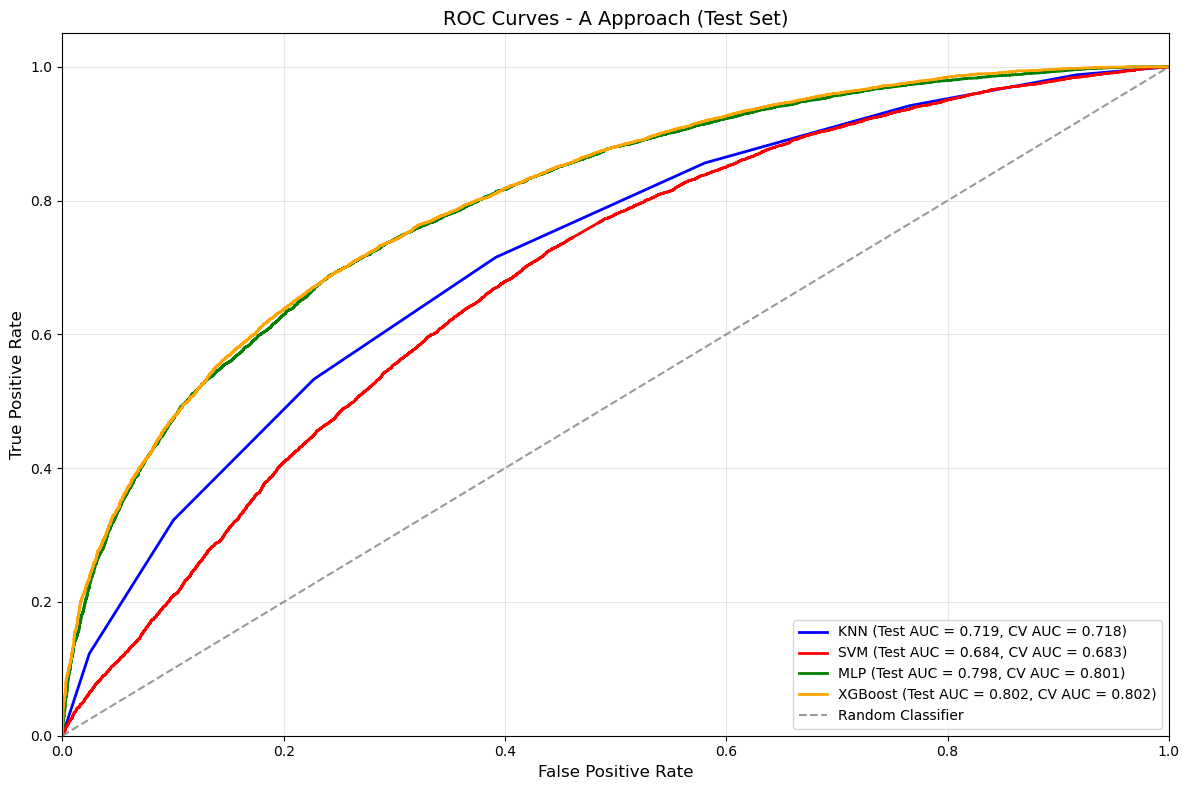


TEST SET PERFORMANSLARI (FLOWCHART A):
--------------------------------------------------


Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', KNeighborsClassifier(n_neighbors=7))])

KNN:
  Accuracy:  0.6647
  Precision: 0.6642
  Recall:    0.6647
  F1:        0.6636
  ROC-AUC:   0.7186



Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

SVM:
  Accuracy:  0.6446
  Precision: 0.6529
  Recall:    0.6446
  F1:        0.6332
  ROC-AUC:   0.6839



Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf', MLPClassifier(max_iter=300))])

MLP:
  Accuracy:  0.7195
  Precision: 0.7194
  Recall:    0.7195
  F1:        0.7194
  ROC-AUC:   0.7982



C:\Users\besir\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:49:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('select', SelectKBest(k=15)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

XGBoost:
  Accuracy:  0.7215
  Precision: 0.7213
  Recall:    0.7215
  F1:        0.7213
  ROC-AUC:   0.8019



In [18]:
# ROC EĞRİLERİ ÇİZİMİ (Train-Test Split ile doğru yaklaşım)
print("\n" + "="*80)
print("ROC EĞRİLERİ ÇİZİMİ")
print("="*80)

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# En iyi yaklaşımı seç (A veya B)
if a_overall_score >= b_overall_score:
    print(f"FLOWCHART A kullanılıyor (en iyi genel performans)")
    best_approach = "A"
    selected_models = best_models
    selected_results = results
else:
    print(f"FLOWCHART B kullanılıyor (en iyi genel performans)")
    best_approach = "B"
    selected_models = best_models_b
    selected_results = results_b

# Veriyi eğitim-test olarak böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ROC çizimi için hazırlık
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']
model_names = list(selected_models.keys())

for i, (name, model_info) in enumerate(selected_models.items()):
    if best_approach == "A":
        # Pipeline kullan
        model = model_info['estimator']
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        # Özellik seçimi + model
        selector_roc = SelectKBest(score_func=f_classif, k=15)
        X_train_selected = selector_roc.fit_transform(X_train, y_train)
        X_test_selected = selector_roc.transform(X_test)
        
        model = model_info['estimator']
        model.fit(X_train_selected, y_train)
        y_scores = model.predict_proba(X_test_selected)[:, 1]
    
    # ROC eğrisi hesapla
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # CV skorunu al
    cv_auc = selected_results[name]['roc_auc']
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f"{name} (Test AUC = {roc_auc:.3f}, CV AUC = {cv_auc:.3f})")

# Diagonal çizgi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.8, label='Random Classifier')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"ROC Curves - {best_approach} Approach (Test Set)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Grafiği göster
plt.tight_layout()
plt.show()

# Test set performansları
print(f"\nTEST SET PERFORMANSLARI (FLOWCHART {best_approach}):")
print("-" * 50)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for name, model_info in selected_models.items():
    if best_approach == "A":
        model = model_info['estimator']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        selector_test = SelectKBest(score_func=f_classif, k=15)
        X_train_selected = selector_test.fit_transform(X_train, y_train)
        X_test_selected = selector_test.transform(X_test)
        
        model = model_info['estimator']
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        y_scores = model.predict_proba(X_test_selected)[:, 1]
    
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='weighted')
    test_rec = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_auc = roc_auc_score(y_test, y_scores)
    
    print(f"{name}:")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall:    {test_rec:.4f}")
    print(f"  F1:        {test_f1:.4f}")
    print(f"  ROC-AUC:   {test_auc:.4f}")
    print()